<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/cadeias_de_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cadeias de Markov com Python
---

O presente modelo é um estudo didático referente a disciplina de Cadeias de Markov do curso do MBA de Pesquisa Operacional e Tomada de Decisão da BsBR.

Como caso de estudo iremos realizar a criação de um modelo para identificar a sequência de eventos mais prováveis de acontecer no treinamento de um modelo de Deep Learning, tendo o foco final colocar esse modelo em Produção.



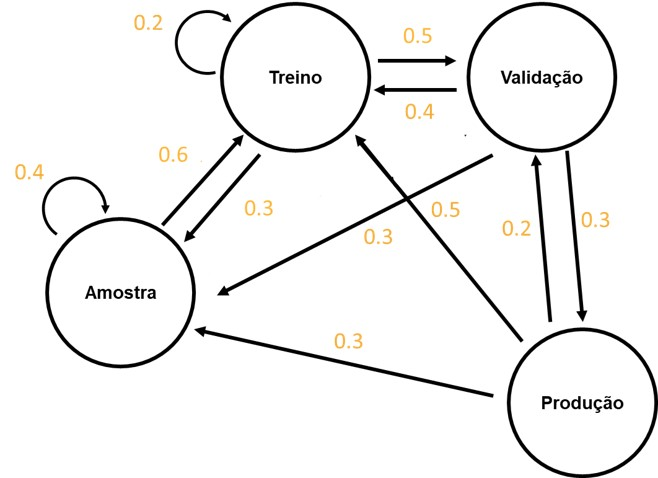

In [1]:
import numpy as np
import random as rm
import pandas as pd
import matplotlib.pyplot as plt

Os dados probabilísticos aqui foram analisando em conjunto com cientistas de dados, avaliando de forma subjetiva como e qual a sequência específicas de eventos nos treinamentos dos seus modelos de deep learning.

In [39]:
estados_desenvolvimento = ["Amostra", "Treino", "Validação","Produção"]
sequencias = [["Amostra -> Amostra", "Amostra -> Treino", "Amostra -> Validação", "Amostra -> Produção"],
              ["Treino -> Amostra", "Treino -> Treino", "Treino -> Validação", "Treino -> Produção"],
              ["Validação -> Amostra", "Validação -> Treino", "Validação -> Validação", "Validação -> Produção"],
              ["Produção -> Amostra", "Produção -> Treino", "Produção -> Validação", "Produção -> Produção"]]

prob_sequencia = [[0.4, 0.6, 0.0, 0.0],
                  [0.3, 0.2, 0.5, 0.0],
                  [0.3, 0.4, 0.0, 0.3],
                  [0.3, 0.5, 0.2, 0.0]]

In [40]:
for idex, value in enumerate(sequencias):
    print(value[0], "Prob:", prob_sequencia[idex][0])
    print(value[1], "Prob:", prob_sequencia[idex][1])
    print(value[2], "Prob:", prob_sequencia[idex][2])
    print(value[3], "Prob:", prob_sequencia[idex][3])

    print("Probabilidade Total", prob_sequencia[idex][0]+prob_sequencia[idex][1]+prob_sequencia[idex][2]+prob_sequencia[idex][3], "\n")

Amostra -> Amostra Prob: 0.4
Amostra -> Treino Prob: 0.6
Amostra -> Validação Prob: 0.0
Amostra -> Produção Prob: 0.0
Probabilidade Total 1.0 

Treino -> Amostra Prob: 0.3
Treino -> Treino Prob: 0.2
Treino -> Validação Prob: 0.5
Treino -> Produção Prob: 0.0
Probabilidade Total 1.0 

Validação -> Amostra Prob: 0.3
Validação -> Treino Prob: 0.4
Validação -> Validação Prob: 0.0
Validação -> Produção Prob: 0.3
Probabilidade Total 1.0 

Produção -> Amostra Prob: 0.3
Produção -> Treino Prob: 0.5
Produção -> Validação Prob: 0.2
Produção -> Produção Prob: 0.0
Probabilidade Total 1.0 



## Crindo script

In [27]:
#Criando classe de Markov
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in range(len(self.states))}
        self.states_dict = {index: self.states[index] for index in range(len(self.states))}

    #Definir função do estado futuro
    def next_state(self,current_state):
        return np.random.choice( self.states,
            p = self.transition_matrix[self.index_dict[current_state], :])

    #Gerar estados d problema
    def generate_states(self, current_state, no = 10):
        future_states = []

        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states

    def generate_especific_states(self, current_state, stop_state):
        future_states = []
        i = 1
        while current_state != stop_state:
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
            i += 1

        return future_states

    def generate_simulation(self, current_state, stop_state, sm = 10):
        n_estados = []
        resultado_sim = []

        for i in range(sm):
            resultado = self.generate_especific_states(current_state, stop_state)
            n_estados.append(len(resultado)+1)
            resultado_sim.append(resultado)

        return n_estados, resultado_sim


In [28]:
atividades_modelo = MarkovChain(transition_matrix = prob_sequencia,
                                states = estados_desenvolvimento)

## Proximo estado

In [42]:
atividades_modelo.next_state(current_state='Amostra')

'Treino'

## Gerando estados futuros

In [43]:
numero_semanas  = 10
resultado = atividades_modelo.generate_states(current_state='Amostra', no = numero_semanas)
resultado

['Treino',
 'Treino',
 'Validação',
 'Treino',
 'Validação',
 'Treino',
 'Amostra',
 'Amostra',
 'Treino',
 'Treino']

In [44]:
resultado_count = pd.DataFrame(resultado).value_counts()
resultado_count

Treino       6
Amostra      2
Validação    2
dtype: int64

## Parando em um estado específico

In [47]:
resultado = atividades_modelo.generate_especific_states(current_state='Amostra', stop_state = "Produção")
resultado

['Treino',
 'Amostra',
 'Amostra',
 'Amostra',
 'Treino',
 'Amostra',
 'Treino',
 'Treino',
 'Amostra',
 'Treino',
 'Validação',
 'Amostra',
 'Amostra',
 'Amostra',
 'Treino',
 'Treino',
 'Treino',
 'Treino',
 'Validação',
 'Produção']

## Simulando

In [78]:
simulacoes = 100

resultado = atividades_modelo.generate_simulation(current_state='Amostra', stop_state = "Produção", sm = simulacoes )

In [79]:
resultado_df  = pd.DataFrame()
resultado_df["Semanas"] = resultado[0]
resultado_df["Resultado"] = resultado[1]
resultado_df["Simulacao"] = 0

for i in range(len(resultado_df["Resultado"])):
    resultado_df["Simulacao"][i] = i+1

<ipython-input-79-4c0e8e98cfd9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado_df["Simulacao"][i] = i+1


In [80]:
resultado_df.head()

,Semanas,Resultado,Simulacao
0,20,"[Amostra, Treino, Treino, Amostra, Amostra, Am...",1
1,4,"[Treino, Validação, Produção]",2
2,11,"[Amostra, Treino, Treino, Validação, Treino, A...",3
3,24,"[Treino, Amostra, Amostra, Treino, Validação, ...",4
4,13,"[Amostra, Amostra, Treino, Validação, Amostra,...",5


In [81]:
resultado_df["Média Semanas"] = np.mean(resultado_df["Semanas"])
resultado_df["Média Semanas"][0] 

18.78

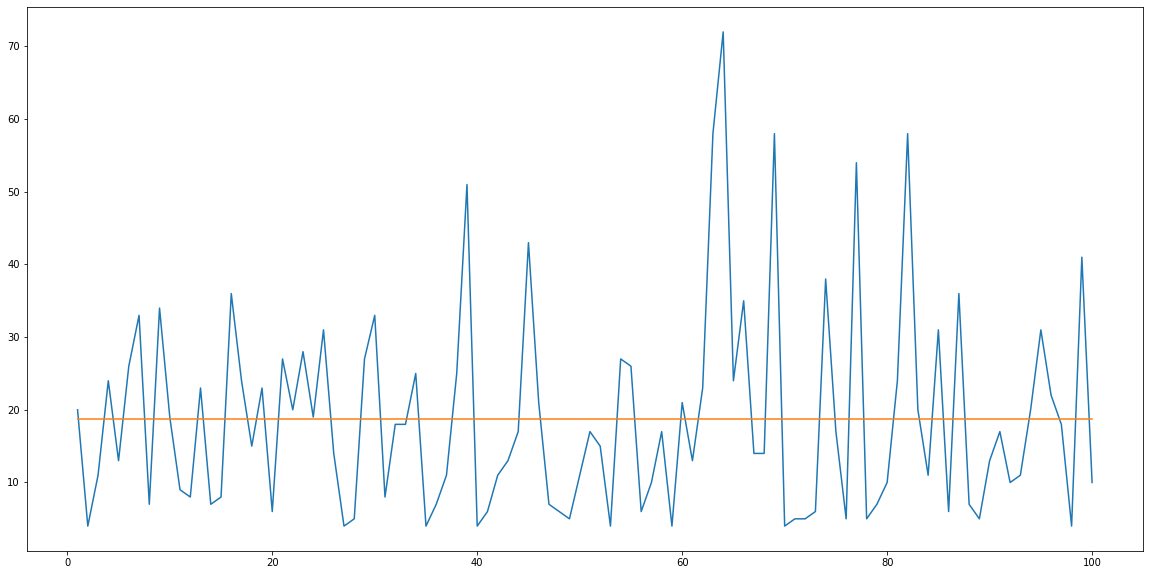

In [82]:
plt.figure(figsize=(20,10)) 
plt.plot(resultado_df["Simulacao"],resultado_df["Semanas"])
plt.plot(resultado_df["Simulacao"],resultado_df["Média Semanas"]);